# Curriculum Access Logs Time Series Project

## Initial questions to answer

 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
     - know this for data science cohorts
     
 2. Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over? 
 
 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students? 
     - data inaccuracy casts doubt on effectiveness of looking at this metric
     
 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses? Any odd user-agents?
 
 5. At some point in the last year, ability for students and alumni to cross-access curriculum (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?
     - there is evidence of Bayes and Curie students accessing Java-i and Java-ii lessons, no access in Darden
     
 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)? 
 
 7. Which lessons are least accessed? 
     - know this for data science
     
 8. Anything else I should be aware of? 
 
 

## Deliverables

- link to GitHub notebook that asks and answers questions - document the work you do to justify findings
- email with the answers to the questions/your findings
    - include the link to your notebook in GitHub
    - attach your slide. 
- be sure that the details you need your need your leader to convey/understand are clearly communicated in the email. 
- Slide should be like an Executive Summary and be in form to present, slide notes for speaking points may also be included 

## Environment Setup

In [1]:
import acquire
import prepare
import wrangle
import summarize
import explore

import numpy as np
import pandas as pd
import math
from datetime import datetime
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

from sklearn import metrics

from scipy.stats import entropy

import matplotlib.dates as mdates #to format dates on our plots

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

explore.set_plotting_defaults()

# Acquire

- read in text dataframes

In [2]:
df = acquire.run()

Acquire: downloading raw data files...
Acquire: Completed!


# Prepare
- exp will be dataframe that is a time series as index
- exp_not_ts will have index that is not time series

- set 44,840 null cohort values to 0
- set 1 null page_viewed value to 0
    - shape = (719459, 13)
- drop page_viewed where the entry is only "/"
    - shape = (679337, 10)

In [3]:
exp, exp_not_ts = prepare.run(df)

Prepare: Cleaning acquired data...
Prepare: Completed! Data not split because no modeling at this time. Full dataset returned.


In [4]:
exp.shape

(679337, 13)

In [5]:
exp_not_ts.head()

,timestamp,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
0,2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018
1,2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018
2,2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018
3,2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,9,Friday,26,1,2018
4,2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,9,Friday,26,1,2018


In [6]:
exp.shape

(679337, 13)

In [7]:
exp[exp.cohort_id == 0]

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2018-01-26 16:46:24,spring/extra-features/form-validation,48,0,97.105.19.61,0,0,0,0.0,16,Friday,26,1,2018
2018-01-26 18:32:17,mysql/relationships/joins,48,0,97.105.19.61,0,0,0,0.0,18,Friday,26,1,2018
2018-01-26 18:32:33,mysql/tables,48,0,97.105.19.61,0,0,0,0.0,18,Friday,26,1,2018
2018-01-26 18:32:37,mysql/databases,48,0,97.105.19.61,0,0,0,0.0,18,Friday,26,1,2018
2018-01-26 18:32:43,mysql/relationships,48,0,97.105.19.61,0,0,0,0.0,18,Friday,26,1,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 16:02:22,java-iii,717,0,136.50.18.157,0,0,0,0.0,16,Monday,2,11,2020
2020-11-02 16:02:26,java-iii/servlets,717,0,136.50.18.157,0,0,0,0.0,16,Monday,2,11,2020
2020-11-02 16:03:50,appendix/further-reading/java/intellij-tomcat-...,727,0,70.94.165.107,0,0,0,0.0,16,Monday,2,11,2020


In [8]:

# df['newcolumn']
# df.loc[df['program_id'] == #, 'newcolumn'] = value

# Explore

<AxesSubplot:xlabel='cohort_id', ylabel='hour'>

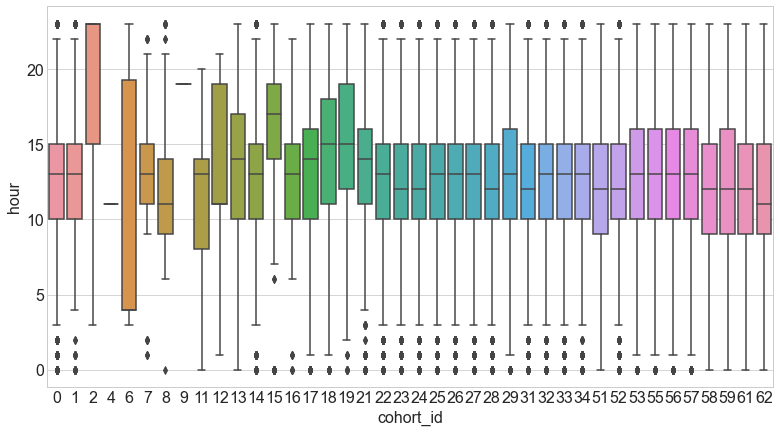

In [9]:
sns.boxplot(data=exp, y='hour', x='cohort_id')

**takeaways**    
- cohort 0 is likely to be instructors
- cohorts 1-3 graduated in 2014
- cohorts 4-9 graduated in 2015
- cohorts 10-14 graduated in 2016
- cohorts 15-20 graduated in 2017
- cohorts 21-25 graduated in 2018
- cohorts 27, 29-33 graduated in 2019
- cohorts 34-58 graduated in 2020
remainder have not yet graduated

- cohort 59 is Darden
- cohort 28 had a name of 'staff' and the date says 2014

Data Science cohorts are program_id 3, the rest would be web dev

Timestamp starts 1/26/2018 so access by cohorts 1 - 20 indicate users who have already graduated. And cohort 21 graduated a month later Feb 2015 so most of their access would be post graduation.


## Isolate Darden cohort as known entity to work on how to find answers to questions
- then attempt to apply out to dataset

In [10]:
darden = exp[exp.name == 'Darden']
darden.head()

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
2020-07-13 14:39:37,1-fundamentals/AI-ML-DL-timeline.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
2020-07-13 14:39:37,1-fundamentals/modern-data-scientist.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
2020-07-13 14:39:53,1-fundamentals/1.1-intro-to-data-science,681,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020


In [11]:
my_ip = '108.239.188.205'
darden[darden.IP == my_ip]

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2020-07-13 14:39:53,1-fundamentals/1.1-intro-to-data-science,681,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
2020-07-13 14:39:54,1-fundamentals/modern-data-scientist.jpg,681,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
2020-07-13 14:39:54,1-fundamentals/AI-ML-DL-timeline.jpg,681,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
2020-07-13 14:47:57,3-sql/1-mysql-overview,681,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
2020-07-13 14:48:02,6-regression/1-overview,681,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 12:34:43,sql/database-design,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,12,Monday,2,11,2020
2020-11-02 12:34:51,timeseries/working-with-time-series-data-with-...,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,12,Monday,2,11,2020
2020-11-02 12:35:06,timeseries/svr,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,12,Monday,2,11,2020


In [12]:
dlist = darden.groupby(['user_id'])['IP', 'page_viewed'].\
                        agg({'IP' : ['nunique'], 'page_viewed': ['count']})
dlist

,IP,page_viewed
,nunique,count
user_id,,
268,3,763
678,2,909
679,1,10
680,4,796
681,1,1157
682,4,1012
683,4,150
684,1,792


### Q3 Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [13]:
darden.user_id.nunique()
# odd that there are 28 unique user ids when class was max 21 people

28

In [14]:
darden.groupby('user_id')['page_viewed'].count().sort_values()

user_id
679      10
697      12
785      29
780      44
783      52
781      83
683     150
693     324
739     461
694     482
690     577
686     608
695     667
687     671
696     761
268     763
684     792
680     796
678     909
691     932
682    1012
681    1157
692    1232
688    1240
699    1340
698    1420
689    1517
685    2343
Name: page_viewed, dtype: int64

In [15]:
darden.groupby('user_id')['page_viewed'].nunique().sort_values()

# show ids with fewest pages_viewed

user_id
679      4
697      9
783     12
785     13
781     20
780     23
683     46
739     75
693    108
686    126
694    131
690    131
678    133
688    140
687    146
695    146
696    147
691    154
684    154
681    155
680    157
689    158
682    159
268    168
692    178
685    187
699    193
698    213
Name: page_viewed, dtype: int64

In [16]:
darden[darden.user_id == 679]
# IP=24.28.146.155, instructor or staff? only accessed afternoon day 1 and morning day 2

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
2020-07-13 14:39:37,1-fundamentals/AI-ML-DL-timeline.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
2020-07-13 14:39:37,1-fundamentals/modern-data-scientist.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
2020-07-13 15:49:31,1-fundamentals/1.1-intro-to-data-science,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,15,Monday,13,7,2020
2020-07-13 15:49:32,1-fundamentals/modern-data-scientist.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,15,Monday,13,7,2020
2020-07-13 15:49:32,1-fundamentals/AI-ML-DL-timeline.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,15,Monday,13,7,2020
2020-07-14 08:05:15,1-fundamentals/1.1-intro-to-data-science,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,8,Tuesday,14,7,2020
2020-07-14 08:05:15,1-fundamentals/AI-ML-DL-timeline.jpg,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,8,Tuesday,14,7,2020


In [17]:
darden[darden.user_id == 697]
# IP=136.50.70.27, instructor or staff? only accessed afternoon day 1

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2020-07-13 15:20:48,3-sql/1-mysql-overview,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,15,Monday,13,7,2020
2020-07-13 15:20:50,1-fundamentals/1.1-intro-to-data-science,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,15,Monday,13,7,2020
2020-07-13 15:20:50,1-fundamentals/modern-data-scientist.jpg,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,15,Monday,13,7,2020
2020-07-13 15:20:50,1-fundamentals/AI-ML-DL-timeline.jpg,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,15,Monday,13,7,2020
2020-07-13 15:20:59,1-fundamentals/1.2-data-science-pipeline,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,15,Monday,13,7,2020
2020-07-13 15:20:59,1-fundamentals/DataToAction_v2.jpg,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,15,Monday,13,7,2020
2020-07-13 15:21:01,1-fundamentals/1.1-intro-to-data-science,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,15,Monday,13,7,2020
2020-07-13 15:21:02,1-fundamentals/AI-ML-DL-timeline.jpg,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,15,Monday,13,7,2020
2020-07-13 15:21:02,1-fundamentals/modern-data-scientist.jpg,697,59,136.50.70.27,Darden,2020-07-13,2021-01-12,3.0,15,Monday,13,7,2020


In [18]:
darden[darden.user_id == 785]
# IP=72.181.127.233, didn't start accessing until October

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2020-10-26 14:35:01,timeseries/acquire,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,14,Monday,26,10,2020
2020-10-27 09:13:52,working-with-time-series-data,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,9,Tuesday,27,10,2020
2020-10-27 09:13:55,working-with-time-series-data,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,9,Tuesday,27,10,2020
2020-10-27 09:13:57,working-with-time-series-data,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,9,Tuesday,27,10,2020
2020-10-27 09:14:02,working-with-time-series-data,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,9,Tuesday,27,10,2020
2020-10-27 09:14:14,sql/mysql-overview,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,9,Tuesday,27,10,2020
2020-10-27 09:14:14,classification/overview,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,9,Tuesday,27,10,2020
2020-10-27 09:14:14,classification/scale_features_or_not.svg,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,9,Tuesday,27,10,2020
2020-10-27 09:14:20,timeseries/overview,785,59,72.181.127.233,Darden,2020-07-13,2021-01-12,3.0,9,Tuesday,27,10,2020


In [19]:
darden[darden.user_id == 780]
# IP=99.132.128.255 didn't start accessing until October

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2020-10-22 14:21:19,timeseries/overview,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,14,Thursday,22,10,2020
2020-10-22 15:35:22,timeseries/acquire,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,15,Thursday,22,10,2020
2020-10-22 18:40:09,regression/acquire-and-prep,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,18,Thursday,22,10,2020
2020-10-22 18:41:01,regression/split-and-scale,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,18,Thursday,22,10,2020
2020-10-22 18:42:11,regression/explore,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,18,Thursday,22,10,2020
2020-10-22 18:43:55,regression/evaluate,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,18,Thursday,22,10,2020
2020-10-22 18:44:54,regression/feature-engineering,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,18,Thursday,22,10,2020
2020-10-22 18:47:04,regression/model,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,18,Thursday,22,10,2020
2020-10-22 18:47:40,regression/project,780,59,99.132.128.255,Darden,2020-07-13,2021-01-12,3.0,18,Thursday,22,10,2020


In [20]:
darden[darden.user_id == 783]
# IP=70.120.16.59, didn't start accessing until October

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2020-10-25 14:34:13,classification/overview,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,14,Sunday,25,10,2020
2020-10-25 14:34:13,classification/scale_features_or_not.svg,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,14,Sunday,25,10,2020
2020-10-25 14:34:16,timeseries/project,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,14,Sunday,25,10,2020
2020-10-25 14:36:54,timeseries/overview,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,14,Sunday,25,10,2020
2020-10-25 14:40:18,timeseries/acquire,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,14,Sunday,25,10,2020
2020-10-25 14:59:52,timeseries/working-with-time-series-data,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,14,Sunday,25,10,2020
2020-10-27 07:44:50,timeseries/prep,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,7,Tuesday,27,10,2020
2020-10-27 07:49:46,timeseries/project,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,7,Tuesday,27,10,2020
2020-10-27 07:49:50,timeseries/explore,783,59,70.120.16.59,Darden,2020-07-13,2021-01-12,3.0,7,Tuesday,27,10,2020


In [21]:
darden[darden.user_id == 781]
# IP=108.239.188.205, didn't start accessing until October
# this is actally ME!! I have 2 user ids 681 and 781

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2020-10-26 08:38:56,classification/overview,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,8,Monday,26,10,2020
2020-10-26 08:38:57,classification/scale_features_or_not.svg,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,8,Monday,26,10,2020
2020-10-26 08:39:02,timeseries/working-with-time-series-data,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,8,Monday,26,10,2020
2020-10-26 09:20:13,timeseries/acquire,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,9,Monday,26,10,2020
2020-10-26 11:54:27,timeseries/acquire,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,11,Monday,26,10,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 12:34:43,sql/database-design,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,12,Monday,2,11,2020
2020-11-02 12:34:51,timeseries/working-with-time-series-data-with-...,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,12,Monday,2,11,2020
2020-11-02 12:35:06,timeseries/svr,781,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,12,Monday,2,11,2020


In [22]:
darden[darden.user_id == 683]
# IP=173.174.165.12, started in July but last access in August = Chris Mora?

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2020-07-13 15:11:07,1-fundamentals/1.1-intro-to-data-science,683,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,15,Monday,13,7,2020
2020-07-13 15:11:07,1-fundamentals/modern-data-scientist.jpg,683,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,15,Monday,13,7,2020
2020-07-13 15:11:07,1-fundamentals/AI-ML-DL-timeline.jpg,683,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,15,Monday,13,7,2020
2020-07-13 19:16:24,1-fundamentals/1.1-intro-to-data-science,683,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,19,Monday,13,7,2020
2020-07-13 19:16:24,1-fundamentals/modern-data-scientist.jpg,683,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,19,Monday,13,7,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-07 08:55:43,python/data-types-and-variables,683,59,70.120.73.115,Darden,2020-07-13,2021-01-12,3.0,8,Friday,7,8,2020
2020-08-07 09:27:52,python/intro-to-matplotlib,683,59,70.120.73.115,Darden,2020-07-13,2021-01-12,3.0,9,Friday,7,8,2020
2020-08-07 11:47:27,python/intro-to-matplotlib,683,59,107.77.222.115,Darden,2020-07-13,2021-01-12,3.0,11,Friday,7,8,2020


In [23]:
darden[darden.user_id == 693]
# IP=136.50.3.247, started in July and continues through present

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2020-07-13 14:47:15,1-fundamentals/1.1-intro-to-data-science,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
2020-07-13 14:47:15,1-fundamentals/modern-data-scientist.jpg,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
2020-07-13 14:47:15,1-fundamentals/AI-ML-DL-timeline.jpg,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020
2020-07-14 16:10:56,appendix/documentation,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,16,Tuesday,14,7,2020
2020-07-14 16:11:44,1-fundamentals/1.1-intro-to-data-science,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,16,Tuesday,14,7,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-28 10:45:26,timeseries/prep,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,10,Wednesday,28,10,2020
2020-10-28 11:21:27,timeseries/explore,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,11,Wednesday,28,10,2020
2020-10-29 10:12:56,timeseries/explore,693,59,136.50.3.247,Darden,2020-07-13,2021-01-12,3.0,10,Thursday,29,10,2020


In [24]:
darden[darden.user_id == 739]
# IP=173.174.165.12, started in Aug and continues through Oct = Gabby?

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2020-08-07 19:17:51,python/intro-to-matplotlib,739,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,19,Friday,7,8,2020
2020-08-07 19:18:16,fundamentals/git,739,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,19,Friday,7,8,2020
2020-08-07 19:29:05,python/intro-to-numpy,739,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,19,Friday,7,8,2020
2020-08-10 11:22:19,python/intro-to-numpy,739,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,11,Monday,10,8,2020
2020-08-10 13:33:55,python/intro-to-numpy,739,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,13,Monday,10,8,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-20 13:32:10,clustering/model,739,59,173.174.165.12,Darden,2020-07-13,2021-01-12,3.0,13,Tuesday,20,10,2020
2020-10-20 14:45:47,clustering/explore,739,59,107.77.219.35,Darden,2020-07-13,2021-01-12,3.0,14,Tuesday,20,10,2020
2020-10-20 14:45:48,clustering/explore,739,59,107.77.219.35,Darden,2020-07-13,2021-01-12,3.0,14,Tuesday,20,10,2020


In [25]:
darden[darden.user_id == 694]
# IP=96.8.130.186, started in JULY and continues through present

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2020-07-13 23:36:01,4-python/4-control-structures,694,59,96.8.130.186,Darden,2020-07-13,2021-01-12,3.0,23,Monday,13,7,2020
2020-07-14 06:03:25,4-python/5-functions,694,59,96.8.130.186,Darden,2020-07-13,2021-01-12,3.0,6,Tuesday,14,7,2020
2020-07-14 06:06:03,4-python/6-imports,694,59,96.8.130.186,Darden,2020-07-13,2021-01-12,3.0,6,Tuesday,14,7,2020
2020-07-14 06:06:39,4-python/4-control-structures,694,59,96.8.130.186,Darden,2020-07-13,2021-01-12,3.0,6,Tuesday,14,7,2020
2020-07-14 06:07:38,4-python/7-working-with-files,694,59,96.8.130.186,Darden,2020-07-13,2021-01-12,3.0,6,Tuesday,14,7,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-29 09:01:01,timeseries/modeling-lesson1,694,59,96.8.130.240,Darden,2020-07-13,2021-01-12,3.0,9,Thursday,29,10,2020
2020-10-29 09:08:39,timeseries/explore,694,59,96.8.130.240,Darden,2020-07-13,2021-01-12,3.0,9,Thursday,29,10,2020
2020-10-29 11:08:41,regression/split-and-scale,694,59,96.8.130.240,Darden,2020-07-13,2021-01-12,3.0,11,Thursday,29,10,2020


In [26]:
co_user_views = darden.groupby('user_id')[['page_viewed']].count().describe()

In [27]:
co_user_views

,page_viewed
count,28.000000
mean,728.000000
std,560.467265
min,10.000000
25%,280.500000
50%,716.000000
75%,1048.250000
max,2343.000000


#### Q3 Answers
- note there are duplicated user_ids (single student with multiple id #s)
    - this makes knowing the total pages per user suspect
- Darden had 2 students drop midway through program (and maybe 2 on first day?)
- 4 user_ids are likely duplicates so just looking at user_id under a certain % doesn't really indicate that the student is below average in use

If duplication and dropped IDs are common throughout this casts doubt on the accuracy mean student usage

In [28]:
# views_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [30]:
clist = set(exp.name.to_list())

# for name in clist:
#     cgroup = exp[exp.name == name]
#     user_views = cgroup.groupby('user_id')['page_viewed'].count().describe()
# #     user_views.columns=[name]
#     co_user_views.append(user_views)


### Q1 Which lesson appears to attract the most traffic consistently across cohorts (per program)?

### Q7 Which lessons are least accessed?

In [32]:
exp.head()

,page_viewed,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year
timestamp,,,,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,9,Friday,26,1,2018
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,9,Friday,26,1,2018


In [33]:
# split the page viewed column to get program language and lesson
program_lesson = exp.page_viewed.str.split('/', expand=True)
program_lesson = program_lesson.drop(columns=[2, 3, 4, 5, 6, 7])
program_lesson.columns = ['lesson', 'sub_lesson']
program_lesson['lesson'] = program_lesson.lesson.str.strip('0123456789-!?')
program_lesson['lesson'] = program_lesson.lesson.str.strip('.123-!?')
exp = pd.concat([exp, program_lesson], axis=1).drop(columns='page_viewed')
exp

,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year,lesson,sub_lesson
timestamp,,,,,,,,,,,,,,
2018-01-26 09:56:02,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018,java-ii,None
2018-01-26 09:56:05,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018,java-ii,object-oriented-programming
2018-01-26 09:56:06,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,9,Friday,26,1,2018,slides,object_oriented_programming
2018-01-26 09:56:24,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,9,Friday,26,1,2018,javascript-i,conditionals
2018-01-26 09:56:41,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0,9,Friday,26,1,2018,javascript-i,loops
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02 16:48:13,763,62,107.192.148.199,Jupiter,2020-09-21,2021-03-30,2.0,16,Monday,2,11,2020,javascript-i,coffee-project
2020-11-02 16:48:17,771,62,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0,16,Monday,2,11,2020,javascript-i,mapbox-api
2020-11-02 16:48:18,771,62,172.125.226.175,Jupiter,2020-09-21,2021-03-30,2.0,16,Monday,2,11,2020,javascript-i,coffee-project


In [34]:
# check for null values
exp.isna().sum()

user_id            0
cohort_id          0
IP                 0
name               0
start_date         0
end_date           0
program_id         0
hour               0
weekday            0
day                0
month              0
year               0
lesson             1
sub_lesson    137801
dtype: int64

In [35]:
# fill null with 0
exp = exp.fillna(0)
exp.isna().sum()

user_id       0
cohort_id     0
IP            0
name          0
start_date    0
end_date      0
program_id    0
hour          0
weekday       0
day           0
month         0
year          0
lesson        0
sub_lesson    0
dtype: int64

In [36]:
darden = exp[exp.name == 'Darden']
darden.head()

,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year,lesson,sub_lesson
timestamp,,,,,,,,,,,,,,
2020-07-13 14:39:21,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020,advanced-topics,1-tidy-data
2020-07-13 14:39:36,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020,fundamentals,1.1-intro-to-data-science
2020-07-13 14:39:37,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020,fundamentals,AI-ML-DL-timeline.jpg
2020-07-13 14:39:37,679,59,24.28.146.155,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020,fundamentals,modern-data-scientist.jpg
2020-07-13 14:39:53,681,59,108.239.188.205,Darden,2020-07-13,2021-01-12,3.0,14,Monday,13,7,2020,fundamentals,1.1-intro-to-data-science


In [39]:
darden.groupby('lesson')[['sub_lesson']].count().sort_values(by='sub_lesson', ascending=False)

,sub_lesson
lesson,
classification,3842
fundamentals,3708
sql,3263
python,2408
stats,1921
regression,1299
clustering,1013
storytelling,890
appendix,688


In [38]:
data_science = exp[exp.program_id == 3]
data_science.nunique()

user_id        71
cohort_id       3
IP            551
name            3
start_date      3
end_date        3
program_id      1
hour           24
weekday         7
day            31
month          12
year            2
lesson         97
sub_lesson    342
dtype: int64

In [40]:
bayes = exp[exp.name == 'Bayes']
bayes.head()

,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year,lesson,sub_lesson
timestamp,,,,,,,,,,,,,,
2019-08-20 09:40:28,470,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,9,Tuesday,20,8,2019,sql,1-mysql-overview
2019-08-20 09:40:30,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,9,Tuesday,20,8,2019,storytelling,bad-charts
2019-08-20 09:40:30,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,9,Tuesday,20,8,2019,storytelling,misleading1_baseball.jpg
2019-08-20 09:40:30,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,9,Tuesday,20,8,2019,storytelling,misleading1_fox.jpg
2019-08-20 09:40:30,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3.0,9,Tuesday,20,8,2019,storytelling,misleading3_deaths.jpg


In [41]:
bayes.groupby('lesson')[['sub_lesson']].count().sort_values(by='sub_lesson', ascending=False)

,sub_lesson
lesson,
fundamentals,3110
regression,2630
python,2447
sql,2360
classification,2016
stats,1988
clustering,1361
appendix,1231
anomaly-detection,1201


In [42]:
curie = exp[exp.name == 'Curie']
curie.head()

,user_id,cohort_id,IP,name,start_date,end_date,program_id,hour,weekday,day,month,year,lesson,sub_lesson
timestamp,,,,,,,,,,,,,,
2020-02-03 15:39:34,575,55,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,15,Monday,3,2,2020,login,0
2020-02-03 15:39:37,575,55,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,15,Monday,3,2,2020,login,0
2020-02-03 15:41:28,585,55,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,15,Monday,3,2,2020,login,0
2020-02-03 15:41:59,582,55,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,15,Monday,3,2,2020,python,1-overview
2020-02-03 15:42:04,576,55,97.105.19.58,Curie,2020-02-03,2020-07-07,3.0,15,Monday,3,2,2020,fundamentals,1.1-intro-to-data-science


In [43]:
curie.groupby('lesson')[['sub_lesson']].count().sort_values(by='sub_lesson', ascending=False)

,sub_lesson
lesson,
sql,2828
python,2459
fundamentals,2381
regression,2020
classification,1449
stats,1325
appendix,1106
anomaly-detection,1000
nlp,793


#### Q1 Answers
- note the dataset only has Bayes, Curie, and Darden datascience cohorts
- there are 97 lesson topics and 342 sub lesson topics
- the most observations Darden:
    - classification +3.5K
    - fundamentals +3.5K
    - sql +3K
    - python +2K
    
- the most observations Curie:
    - sql +2.5K
    - python +2K
    - fundamentals +2K
    - regression +2K

- the most observations Bayes:
    - fundamentals +3K
    - regression +2.5K
    - python +2K
    - sql +2K
    

#### Q7 Answers
- note the dataset only has Bayes, Curie, and Darden datascience cohorts
- there are 97 lesson topics and 342 sub lesson topics
- **the least observations Darden:**
    - pipeline-demo	4
    - pandas-overview	4
    - refine	3
    - simulation	3
    - present	2
    - intro-to-matplotlib	2
    - prep	2
    - split-and-scale	2
    - create	2
    - compare-means	2
    - api	2
    - functions	2
    - imports	1
    - scale_features_or_not.svg	1
    - explore	1
    - spreadsheets-overview	1
    - bad-charts	1
    - vocabulary	1

    
- **the least observations Curie:**
    - login	4
    - curie-python-assessemt	3
    - project	2
    - probability-distributions	2
    - grades	2
    - data-types-and-variables	2
    - databases	2
    - AnomalyDetectionCartoon.jpeg	2
    - 5-more-statistical-testing-examples	2
    - acquire	2
    - curie-stats-assessment	2
    - modern-data-scientist.jpg	1
    - curie-statistics-assessment	1
    - compare-means	1
    - b-clustering	1
    - AI-ML-DL-timeline.jpg	1
    - A-clustering	1
    - statistics-assessment	1
    - java-ii	1
    - stats-assessment	1


- **the least observations Bayes:**
    - jquery	4
    - javascript-ii	4
    - java-iii	4
    - java-ii	4
    - Pipeline_Demo	4
    - bayes-python-assessment-4586.html	4
    - find_me_curie!(12.3.19)	4
    - _Understand	3
    - cli	3
    - mysql	3
    - overview	2
    - detecting-timeseries-anomalies	2
    - examples	2
    - ltc.-ml	2
    - misleading3_deaths.jpg	1
    - mkdocs	1
    - 4.1-pandas-overview	1
    - misleading1_fox.jpg	1
    - misleading1_baseball.jpg	1
    - itc-ml	1
    - 4.2-series	1
    - index.html	1
    - git	1
    - end_to_end_clustering	1
    - detecting-with-clustering	1
    - database-design	1
    - capstones	1
    - Index.html	1
    - Hospital-Distance-Clusters.jpg	1
    - End_to_End_clustering	1


### Q2 Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over?

#### Q2 Answers

### Q5 At some point in the last year, ability for students and alumni to cross-access curriculum (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

#### Q5 Answer
- note there was access in Bayes to Java i and Java ii
- also in Curie java ii

need to check dates

### Q4 Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses? Any odd user-agents?

#### Q4 Answers

### Q6 What topics are grads continuing to reference after graduation and into their jobs (for each program)? 

#### Q6 Answers